(29, 65) (29, 2) ['SFCL_TMP', '0925_TMP', '0850_TMP', '0700_TMP', '0500_TMP', 'SFCL_UGRD', '0925_UGRD', '0850_UGRD', '0700_UGRD', '0500_UGRD', 'SFCL_VGRD', '0925_VGRD', '0850_VGRD', '0700_VGRD', '0500_VGRD', 'SFCL_RH', '0925_RH', '0850_RH', '0700_RH', '0500_RH', 'SFCL_PRMSL', 'SFCL_PCP', 'SFCL_TD', '0850_TD', '0700_TD', '0500_TD', '0850_MRH', '0700_MRH', '0500_MRH', '0850_TTD', '0700_TTD', '0500_TTD', '0850_NE', '0700_NE', '0500_NE', '0850_NW', '0700_NW', '0500_NW', '0850_WS', '0700_WS', '0500_WS', 'SFCL_SPHU', '0850_SPHU', '0850_DIFQ', '0700_DIFQ', '0925_HGT', '0850_HGT', '0700_HGT', '0500_HGT', '0850_THCK', '0700_THCK', '0500_THCK', '0000_PCWT', '0000_LSRT', '0000_LFIDX', '0000_SWIDX', '0000_SKY', '0000_SSI', 'SFCL_HPBL', 'SFCL_VIS', '0925_DZDT', '0850_DZDT', '0700_DZDT', '0500_DZDT', 'SFCL_STABL'] <class 'list'>
(29, 65) (29, 2)
after drop missing
(29, 65) (29, 2)
RandomForest Regressor ing..
Features sorted by their score:
Feature ranking:
65. feature 59 SFCL_VIS (0.000438)
64. fea

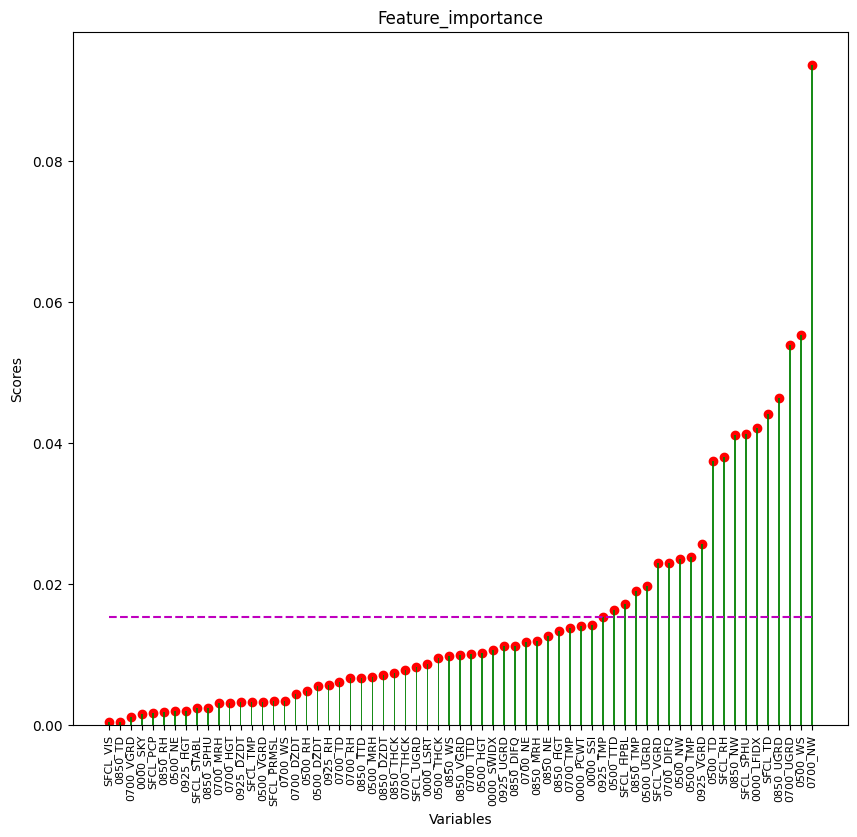

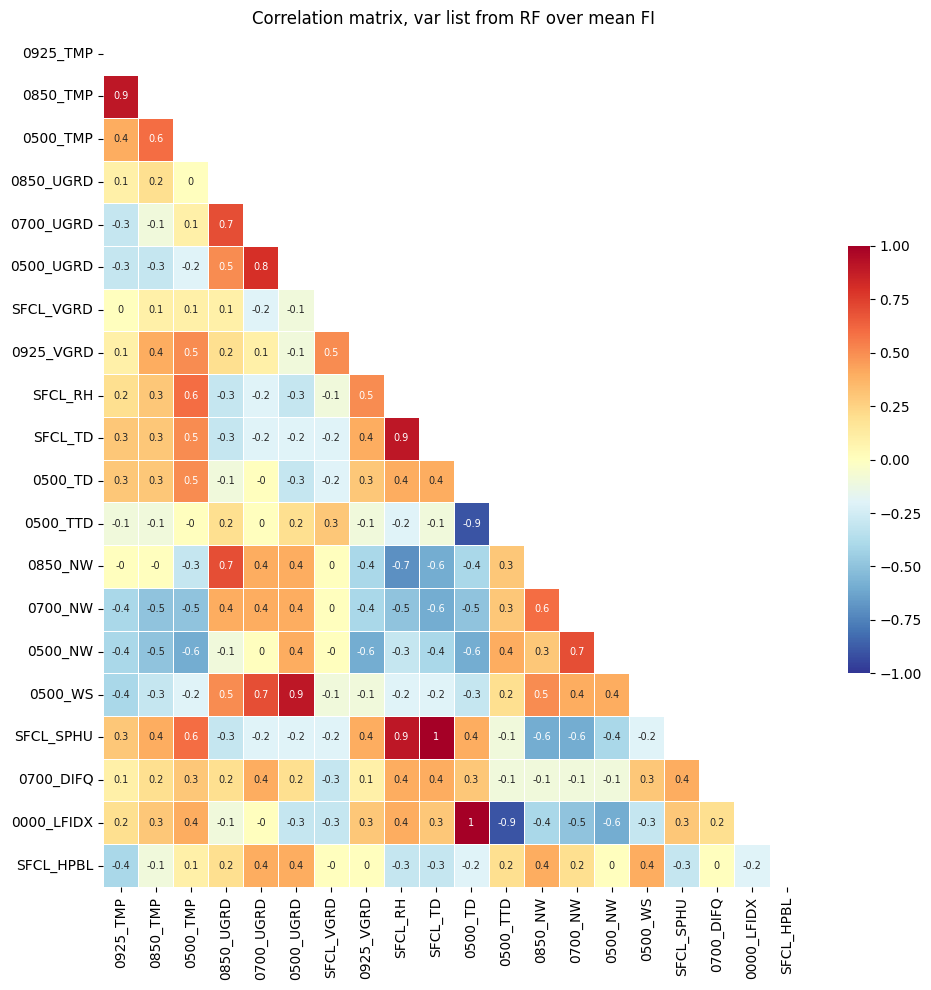

In [1]:
#----------------------------------------------------------------------------
# .. module load
import numpy as np
#from BorutaShap import BorutaShap
#from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os
import sys
import time
import joblib

#.. local
sys.path.insert(0, '../inc')
from plot_importance import plot_importance_barh, plot_importance_hline
from cr_matrix import plot_correlation_matrix
from get_importance import get_feature_importances


#----------------------------------------------------------------------------
# .. Load data
input_dir = "../dat/"
print_dir = "../out/"
#data_per = "2016050100-2021043000-24-1605-2104"
data_per = "sample"
#data_per = "test1stn"
input_x = "test_nwp_" + data_per
input_y = "test_obs_" + data_per

nwp = np.load(input_dir + input_x + ".npz")['value']
obs = np.load(input_dir + input_y + ".npz")['value']
header = np.load(input_dir + input_x + ".npz")['value_name']
header = header.tolist()

print (np.shape(nwp), np.shape(obs), header, type(header)) # variable, day, forecast_time
X = nwp
y = obs


print (np.shape(X), np.shape(y)) # forecast_time * day, variable

# .. remove missing
missing_idx = np.where( X==-999. )
X = np.delete( X, missing_idx[0], axis=0 )
y = np.delete( y, missing_idx[0], axis=0 )

print ( "after drop missing" )
print (np.shape(X), np.shape(y)) # forecast_time * day, variable


#----------------------------------------------------------------------------
# .. model run

# .. set model & fit
print("RandomForest Regressor ing..")
forest = RandomForestRegressor(n_jobs=-1, criterion='squared_error', max_depth=30,  ## max_depth=5
                           min_samples_split=3, max_features=0.33, random_state=1)
#forest = RandomForestRegressor(n_jobs=-1, criterion='mse', random_state=0)
#forest = RandomForestRegressor(n_estimators= 2, n_jobs=-1, random_state=0)
forest.fit(X, y)


# .. get feature importance
print( "Features sorted by their score:")
importances = forest.feature_importances_

# .. sort importance
indices = np.argsort(importances)[::-1]
sorted_importances= []
sorted_feature_name= []
print("Feature ranking:")
feature_name = header
for f in range(X.shape[1]-1,-1,-1):
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) )
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], feature_name[indices[f]], importances[indices[f]]) )
    sorted_importances.append(importances[indices[f]])
    sorted_feature_name.append(feature_name[indices[f]])
    
# .. save RF result
save_name = print_dir + "rf_hline_" + data_per
print(save_name)

plot_importance_hline(sorted_feature_name, sorted_importances, save_name)
joblib.dump(forest, "../daba/" + "rf_regressor_" + data_per)


#----------------------------------------------------------------------------
# .. feature select over mean

# .. select variable
sfm = SelectFromModel(estimator=forest, prefit=True, threshold='mean', max_features=None)
sel_idx=sfm.get_support()
print("sel idx: ", sel_idx)
filter_X = X[:,sel_idx]
filter_H = list(np.array(header)[sel_idx])
print("after select variable: ", filter_X.shape)

save_name = print_dir + "cr_matrix_" + data_per
plot_correlation_matrix(filter_X, filter_H, save_name)

